In [103]:
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pandas as pd
import numpy as np
import random
import os

In [104]:
def set_seeds(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seeds(42)

In [105]:
spark = SparkSession.builder \
            .appName("VBMA VAR") \
            .config("spark.sql.catalog.nessie.ref", "feature/fact-macro-build") \
            .getOrCreate()

### Load data from Gold layer

In [106]:
dim_time = spark.read.format("iceberg").load("nessie.gold.dim_time")
dim_industry = spark.read.format("iceberg").load("nessie.gold.dim_industry")
dim_indicator = spark.read.format("iceberg").load("nessie.gold.dim_indicator")
fact_df = spark.read.format("iceberg").load("nessie.gold.fact_macro")

In [107]:
fact_df.show()

+--------------------+--------+--------------------+--------------------+-----------+
|       fact_macro_id|time_key|        industry_key|       indicator_key|      value|
+--------------------+--------+--------------------+--------------------+-----------+
|3e1fa7fc-6c36-458...|20201201|e5ca4ca4-3b65-4ce...|8ca7537f-c2ab-474...|        1.0|
|34d0c662-aaf1-413...|20201201|b2bb032c-4e93-44f...|8ca7537f-c2ab-474...|        1.0|
|32842382-b8ee-4cc...|20201201|8b01c71f-d49c-43f...|8ca7537f-c2ab-474...|        1.0|
|6366c15d-2e27-42b...|20201201|93f6fb33-b873-4ff...|8ca7537f-c2ab-474...|        1.0|
|45d70800-0849-4b4...|20210101|e5ca4ca4-3b65-4ce...|8ca7537f-c2ab-474...|     1.0064|
|38a54ef0-cdb7-4c4...|20210101|b2bb032c-4e93-44f...|8ca7537f-c2ab-474...|     0.9769|
|3786699e-5bff-415...|20210101|8b01c71f-d49c-43f...|8ca7537f-c2ab-474...|        1.0|
|d113b11b-455b-417...|20210101|93f6fb33-b873-4ff...|8ca7537f-c2ab-474...|     1.0229|
|8d0bfcb8-028e-46f...|20210201|e5ca4ca4-3b65-4ce...|8c

### Prepare data for training

In [108]:
macro_df = fact_df \
    .join(dim_time, fact_df.time_key == dim_time.time_key, "inner")
macro_df = macro_df \
    .join(dim_industry, macro_df.industry_key == dim_industry.industry_key, "inner")
macro_df = macro_df \
    .join(dim_indicator, macro_df.indicator_key == dim_indicator.indicator_key, "inner")

macro_df = macro_df.select(
    'full_date',
    'industry',
    'indicator_code',
    'value'
)

macro_df.show()

+----------+---------------+--------------+-----------+
| full_date|       industry|indicator_code|      value|
+----------+---------------+--------------+-----------+
|2020-12-01|      Thực phẩm|           CPI|        1.0|
|2020-12-01|Nhà, điện, nước|           CPI|        1.0|
|2020-12-01|           Y tế|           CPI|        1.0|
|2020-12-01|        Vận tải|           CPI|        1.0|
|2021-01-01|      Thực phẩm|           CPI|     1.0064|
|2021-01-01|Nhà, điện, nước|           CPI|     0.9769|
|2021-01-01|           Y tế|           CPI|        1.0|
|2021-01-01|        Vận tải|           CPI|     1.0229|
|2021-02-01|      Thực phẩm|           CPI| 1.02260304|
|2021-02-01|Nhà, điện, nước|           CPI|   1.015976|
|2021-02-01|           Y tế|           CPI|        1.0|
|2021-02-01|        Vận tải|           CPI| 1.03875495|
|2021-03-01|      Thực phẩm|           CPI|1.007673036|
|2021-03-01|Nhà, điện, nước|           CPI|1.018414342|
|2021-03-01|           Y tế|           CPI|     

In [109]:
# Get average value by indicator_code and full_date
macro_df = macro_df.groupBy('indicator_code', 'full_date').agg(F.avg('value').alias('avg_value'))
macro_df.show()

+--------------+----------+------------------+
|indicator_code| full_date|         avg_value|
+--------------+----------+------------------+
|           CPI|2022-08-01|1.0794998902500001|
|           CPI|2021-12-01|     1.04347009475|
|           CPI|2022-03-01|       1.077647437|
|           CPI|2022-10-01|1.0714214682499998|
|           CPI|2021-08-01|     1.04249517475|
|           CPI|2022-01-01|      1.0470634925|
|           CPI|2022-04-01|      1.0771678795|
|           CPI|2021-11-01|     1.04919780025|
|           CPI|2021-03-01|1.0221824539999997|
|           CPI|2021-02-01|      1.0193334975|
|           CPI|2021-10-01|      1.0395780225|
|           CPI|2021-06-01|     1.03041237675|
|           CPI|2021-05-01|      1.0262222605|
|           CPI|2022-02-01|      1.0601428505|
|           CPI|2022-11-01|1.0803056205000001|
|           CPI|2021-04-01|       1.023071195|
|           CPI|2021-01-01|           1.00155|
|           CPI|2022-07-01|      1.0937919875|
|           C

In [110]:
macro_df.select('indicator_code').distinct().show(truncate=False)

+------------------------+
|indicator_code          |
+------------------------+
|CPI                     |
|GDP_NOMINAL             |
|GDP_REAL                |
|INFLATION_BY_INDUSTRY   |
|GDP_GROWTH_RATE         |
|GDP_REAL_GROWTH_RATE    |
|FDI_DISBURSED_VALUE     |
|FDI_DISBURSED_YOY       |
|FDI_REGISTERED_VALUE    |
|FDI_REGISTERED_YOY      |
|FDI_NEW_PLUS_CAP_VALUE  |
|FDI_NEW_PLUS_CAP_YOY    |
|FDI_SHARE_PURCHASE_VALUE|
|FDI_SHARE_PURCHASE_YOY  |
+------------------------+



In [111]:
macro_df = macro_df.filter(F.col('indicator_code').isin(['CPI', 'INFLATION_BY_INDUSTRY', 'GDP_REAL']))
macro_df.show()

+--------------+----------+------------------+
|indicator_code| full_date|         avg_value|
+--------------+----------+------------------+
|           CPI|2022-08-01|1.0794998902500001|
|           CPI|2021-12-01|     1.04347009475|
|           CPI|2022-03-01|       1.077647437|
|           CPI|2022-10-01|1.0714214682499998|
|           CPI|2021-08-01|     1.04249517475|
|           CPI|2022-01-01|      1.0470634925|
|           CPI|2022-04-01|      1.0771678795|
|           CPI|2021-11-01|     1.04919780025|
|           CPI|2021-03-01|1.0221824539999997|
|           CPI|2021-02-01|      1.0193334975|
|           CPI|2021-10-01|      1.0395780225|
|           CPI|2021-06-01|     1.03041237675|
|           CPI|2021-05-01|      1.0262222605|
|           CPI|2022-02-01|      1.0601428505|
|           CPI|2022-11-01|1.0803056205000001|
|           CPI|2021-04-01|       1.023071195|
|           CPI|2021-01-01|           1.00155|
|           CPI|2022-07-01|      1.0937919875|
|           C

In [112]:
# pivot the table to wide format
macro_df = macro_df.groupBy('full_date').pivot('indicator_code').agg(F.first('avg_value'))
macro_df.show()

+----------+------------------+------------------+---------------------+
| full_date|               CPI|          GDP_REAL|INFLATION_BY_INDUSTRY|
+----------+------------------+------------------+---------------------+
|2016-03-01|              NULL| 61151.88888888889|                 NULL|
|2019-11-01|              NULL|129561.27777777778|                 NULL|
|2025-02-01|      1.2097850875|162437.94444444444|               3.6125|
|2018-09-01|              NULL| 95881.66666666667|                 NULL|
|2018-11-01|              NULL|121272.44444444444|                 NULL|
|2015-04-01|              NULL| 74676.22222222222|                 NULL|
|2023-01-01|      1.0800957235|142830.94444444444|              4.59375|
|2015-08-01|              NULL| 78582.05555555556|                 NULL|
|2024-12-01|     1.16213789725|189751.77777777778|   2.7187499999999996|
|2016-01-01|              NULL| 61151.88888888889|                 NULL|
|2022-05-01|     1.08482567475|144953.61111111112| 

In [113]:
macro_df = macro_df.sort('full_date')
macro_df.show(50)

+----------+----+------------------+---------------------+
| full_date| CPI|          GDP_REAL|INFLATION_BY_INDUSTRY|
+----------+----+------------------+---------------------+
|2015-01-01|NULL|54327.055555555555|                 NULL|
|2015-02-01|NULL|54327.055555555555|                 NULL|
|2015-03-01|NULL|54327.055555555555|                 NULL|
|2015-04-01|NULL| 74676.22222222222|                 NULL|
|2015-05-01|NULL| 74676.22222222222|                 NULL|
|2015-06-01|NULL| 74676.22222222222|                 NULL|
|2015-07-01|NULL| 78582.05555555556|                 NULL|
|2015-08-01|NULL| 78582.05555555556|                 NULL|
|2015-09-01|NULL| 78582.05555555556|                 NULL|
|2015-10-01|NULL| 98710.77777777778|                 NULL|
|2015-11-01|NULL| 98710.77777777778|                 NULL|
|2015-12-01|NULL| 98710.77777777778|                 NULL|
|2016-01-01|NULL| 61151.88888888889|                 NULL|
|2016-02-01|NULL| 61151.88888888889|                 NUL

In [114]:
macro_pd = macro_df.toPandas()
macro_pd

,full_date,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,2015-01-01,NaN,54327.055556,NaN
1,2015-02-01,NaN,54327.055556,NaN
2,2015-03-01,NaN,54327.055556,NaN
3,2015-04-01,NaN,74676.222222,NaN
4,2015-05-01,NaN,74676.222222,NaN
...,...,...,...,...
125,2025-06-01,1.217057,177008.833333,4.06250
126,2025-07-01,1.217246,182017.055556,3.66875
127,2025-08-01,1.217380,182017.055556,3.68750
128,2025-09-01,1.221520,182017.055556,3.78125


In [115]:
macro_pd = macro_pd.fillna(method='ffill')
macro_pd = macro_pd.fillna(method='bfill')
macro_pd

,full_date,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,2015-01-01,1.000000,54327.055556,0.26875
1,2015-02-01,1.000000,54327.055556,0.26875
2,2015-03-01,1.000000,54327.055556,0.26875
3,2015-04-01,1.000000,74676.222222,0.26875
4,2015-05-01,1.000000,74676.222222,0.26875
...,...,...,...,...
125,2025-06-01,1.217057,177008.833333,4.06250
126,2025-07-01,1.217246,182017.055556,3.66875
127,2025-08-01,1.217380,182017.055556,3.68750
128,2025-09-01,1.221520,182017.055556,3.78125


In [116]:
macro_pd = macro_pd.drop(columns=['full_date']) 
macro_pd

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,1.000000,54327.055556,0.26875
1,1.000000,54327.055556,0.26875
2,1.000000,54327.055556,0.26875
3,1.000000,74676.222222,0.26875
4,1.000000,74676.222222,0.26875
...,...,...,...
125,1.217057,177008.833333,4.06250
126,1.217246,182017.055556,3.66875
127,1.217380,182017.055556,3.68750
128,1.221520,182017.055556,3.78125


In [117]:
# Split data into train and test sets
train_size = int(len(macro_pd) * 0.8)   
train_data = macro_pd.iloc[:train_size]
test_data = macro_pd.iloc[train_size:]
print(f'Train data shape: {train_data.shape}')
print(f'Test data shape: {test_data.shape}')

Train data shape: (104, 3)
Test data shape: (26, 3)


In [118]:
train_data

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,1.000000,54327.055556,0.26875
1,1.000000,54327.055556,0.26875
2,1.000000,54327.055556,0.26875
3,1.000000,74676.222222,0.26875
4,1.000000,74676.222222,0.26875
...,...,...,...
99,1.087810,151297.055556,2.75000
100,1.082276,151297.055556,2.41250
101,1.084445,151297.055556,2.13750
102,1.087942,155516.444444,3.05000


In [119]:
test_data

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
104,1.112547,155516.444444,3.60625
105,1.108852,175797.500000,3.59375
106,1.118731,175797.500000,4.06250
107,1.121832,175797.500000,4.48125
108,1.128707,150991.666667,4.41875
109,1.143820,150991.666667,5.00000
110,1.142446,150991.666667,5.10625
111,1.151929,151275.666667,5.20625
112,1.148690,151275.666667,5.21875
113,1.146894,151275.666667,5.16250


### Scaling data

In [120]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller, grangercausalitytests
from statsmodels.tsa.api import VAR
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, ParameterGrid
from tqdm.notebook import tqdm_notebook
from typing import Union

In [121]:
# Scaled function
scalers = {}
def scale_data(df: pd.DataFrame):
    scaled_df = df.copy()
    for name in df.columns:
        scaler = MinMaxScaler(feature_range=(-1, 1))
        scaled_df[name] = scaler.fit_transform(df[name].values.reshape(-1, 1)).ravel()
        scalers[name] = scaler
    return scaled_df

In [122]:
scalers = {}
def scale_data(df: pd.DataFrame):
    """
    - Lần đầu gọi (train): fit scaler + transform
    - Lần sau (test): dùng scaler đã fit trên train để transform
    """
    scaled_df = df.copy()
    for name in df.columns:
        if name not in scalers:
            scaler = MinMaxScaler(feature_range=(-1, 1))
            scaled_df[name] = scaler.fit_transform(df[name].values.reshape(-1, 1)).ravel()
            scalers[name] = scaler
        else:
            scaler = scalers[name]
            scaled_df[name] = scaler.transform(df[name].values.reshape(-1, 1)).ravel()
    return scaled_df

In [123]:
scaled_train = scale_data(train_data)
scaled_test = scale_data(test_data)

In [124]:
scalers

{'CPI': MinMaxScaler(feature_range=(-1, 1)),
 'GDP_REAL': MinMaxScaler(feature_range=(-1, 1)),
 'INFLATION_BY_INDUSTRY': MinMaxScaler(feature_range=(-1, 1))}

In [125]:
scaled_train

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
0,-1.000000,-1.000000,-1.000000
1,-1.000000,-1.000000,-1.000000
2,-1.000000,-1.000000,-1.000000
3,-1.000000,-0.631005,-1.000000
4,-1.000000,-0.631005,-1.000000
...,...,...,...
99,0.694461,0.758373,0.147399
100,0.587673,0.758373,-0.008671
101,0.629517,0.758373,-0.135838
102,0.697000,0.834884,0.286127


In [126]:
scaled_test

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
104,1.171807,0.834884,0.543353
105,1.100512,1.202644,0.537572
106,1.291135,1.202644,0.754335
107,1.350976,1.202644,0.947977
108,1.483643,0.752836,0.919075
109,1.775282,0.752836,1.187861
110,1.748760,0.752836,1.236994
111,1.931761,0.757986,1.283237
112,1.869245,0.757986,1.289017
113,1.834605,0.757986,1.263006


### ADF Testing

In [127]:
def adf_test(df: pd.DataFrame) -> pd.DataFrame:
    result = []
    for col in df.columns:
        stat, p_value, *_ = adfuller(df[col])
        result.append({
            'Variable': col,
            'Statistic': stat,
            'p-value': round(p_value, 5),
            'Stationary': p_value < 0.05
        })
    return pd.DataFrame(result, index=df.columns)

In [128]:
def check_stationarity(df: pd.DataFrame) -> bool:
    return df['Stationary'].all()

In [129]:
adf_test(scaled_train)

,Variable,Statistic,p-value,Stationary
CPI,CPI,1.252264,0.99633,False
GDP_REAL,GDP_REAL,0.140868,0.96874,False
INFLATION_BY_INDUSTRY,INFLATION_BY_INDUSTRY,2.377081,0.99900,False


In [130]:
train_diff = scaled_train.diff().dropna()
order = 1 # Bậc sai phân

while not check_stationarity(adf_test(train_diff)):
    order += 1
    train_diff = train_diff.diff(periods=order).dropna()

print(f'Bậc sai phân: {order}')

Bậc sai phân: 2


In [131]:
order = 0
train_diff = scaled_train.copy()

while True:
    adf_result = adf_test(train_diff)
    if check_stationarity(adf_result):
        break
    train_diff = train_diff.diff().dropna()
    order += 1

print(f'Bậc sai phân: {order}')

Bậc sai phân: 2


In [132]:
scaled_test

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
104,1.171807,0.834884,0.543353
105,1.100512,1.202644,0.537572
106,1.291135,1.202644,0.754335
107,1.350976,1.202644,0.947977
108,1.483643,0.752836,0.919075
109,1.775282,0.752836,1.187861
110,1.748760,0.752836,1.236994
111,1.931761,0.757986,1.283237
112,1.869245,0.757986,1.289017
113,1.834605,0.757986,1.263006


In [133]:
test_diff = scaled_test.diff(periods=order).dropna()
test_diff

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
106,0.119329,0.367760,0.210983
107,0.250464,0.000000,0.410405
108,0.192507,-0.449808,0.164740
109,0.424306,-0.449808,0.239884
110,0.265118,0.000000,0.317919
111,0.156479,0.005150,0.095376
112,0.120484,0.005150,0.052023
113,-0.097156,0.000000,-0.020231
114,0.098566,0.292671,-0.002890
115,0.058929,0.292671,-0.320809


In [134]:
test_diff = scaled_test.copy()
for _ in range(order):
    test_diff = test_diff.diff().dropna()

test_diff

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
106,0.261918,-0.367760,2.225434e-01
107,-0.130783,0.000000,-2.312139e-02
108,0.072825,-0.449808,-2.225434e-01
109,0.158973,0.449808,2.976879e-01
110,-0.318161,0.000000,-2.196532e-01
111,0.209522,0.005150,-2.890173e-03
112,-0.245517,-0.005150,-4.046243e-02
113,0.027877,0.000000,-3.179191e-02
114,0.167845,0.292671,4.913295e-02
115,-0.207481,-0.292671,-3.670520e-01


In [135]:
adf_test(train_diff)

,Variable,Statistic,p-value,Stationary
CPI,CPI,-6.491813,0.00000,True
GDP_REAL,GDP_REAL,-15.791113,0.00000,True
INFLATION_BY_INDUSTRY,INFLATION_BY_INDUSTRY,-5.204355,0.00001,True


### Finding optimize lag

In [136]:
def select_lag(endog: Union[pd.DataFrame, list], max_lag: int = 30) -> pd.DataFrame:
    model = VAR(endog)
    results = []

    fitted = None
    for lag in range(0, max_lag + 1):
        try:
            fitted = model.select_order(maxlags=lag)
        except Exception as e:
            print(f"Error fitting model with lag {lag}: {e}")
            continue
    print(fitted.summary())

In [137]:
select_lag(train_diff, max_lag=30)

Error fitting model with lag 25: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 26: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 27: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 28: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 29: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
Error fitting model with lag 30: maxlags is too large for the number of observations and the number of equations. The largest model cannot be estimated.
 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         

In [138]:
train_diff

,CPI,GDP_REAL,INFLATION_BY_INDUSTRY
2,0.000000,0.000000,0.000000
3,0.000000,0.368995,0.000000
4,0.000000,-0.368995,0.000000
5,0.000000,0.000000,0.000000
6,0.000000,0.070825,0.000000
...,...,...,...
99,-0.021043,0.153517,0.063584
100,-0.068054,-0.153517,0.106936
101,0.148632,0.000000,0.028902
102,0.025638,0.076511,0.549133


In [139]:
def granger_causality_matrix(df, max_lag) -> pd.DataFrame:
    variables = df.columns
    results = pd.DataFrame(index=variables, columns=variables)

    for cause in variables:
        for effect in variables:
            try:
                test_result = grangercausalitytests(
                    df[[effect, cause]],
                    max_lag,
                    verbose=False
                )

                p_values = [
                    round(result[0]['ssr_ftest'][1], 4)
                    for result in test_result.values()
                ]

                results.loc[effect, cause] = np.min(p_values)

            except Exception as e:
                results.loc[effect, cause] = np.nan

    # Rename columns for clarity
    results.index = [f"{var}_y" for var in variables]
    results.columns = [f"{var}_x" for var in variables]

    return results

In [140]:
lag = 20
no_columns = len(train_diff.columns)
granger_causality_matrix(train_diff, lag)

,CPI_x,GDP_REAL_x,INFLATION_BY_INDUSTRY_x
CPI_y,1.0,0.0,0.0
GDP_REAL_y,0.1825,1.0,0.8199
INFLATION_BY_INDUSTRY_y,NaN,0.0,1.0


# Training VAR

In [141]:
model = VAR(train_diff)
fitted = model.fit(maxlags=lag)

# Training without scale

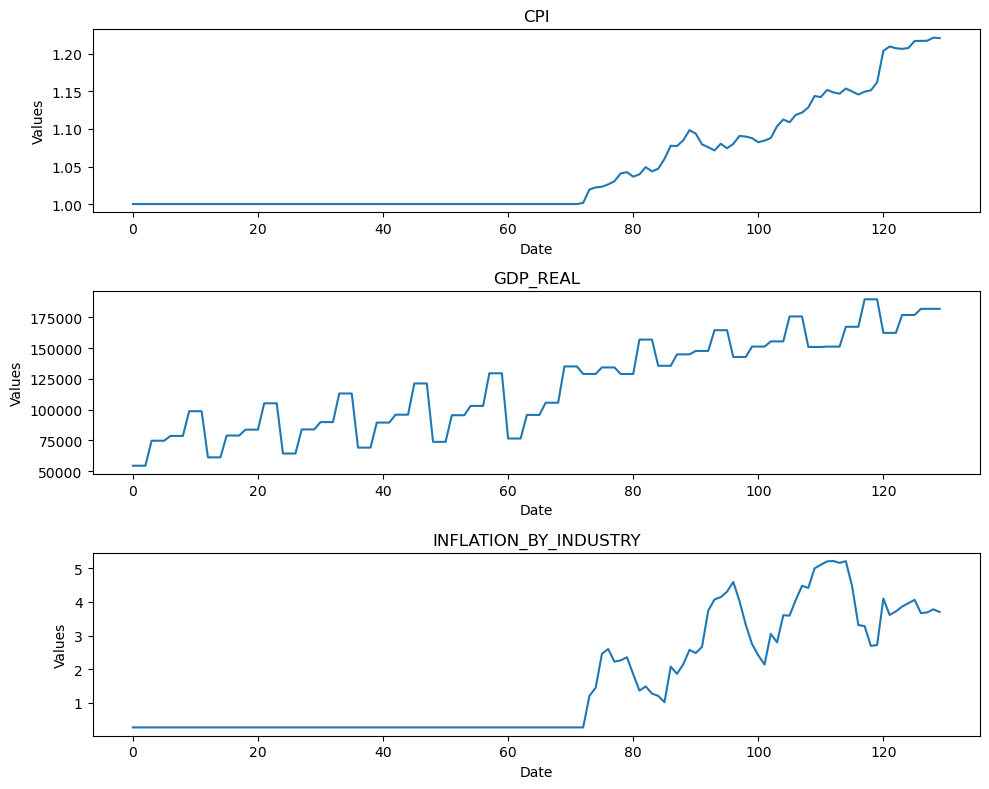

In [142]:
def plot_series(data):
    fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 8))
    for i, col in enumerate(data.columns):
        data[col].plot(ax=axes[i], title=col)
        axes[i].set_ylabel('Values')
        axes[i].set_xlabel('Date')
    plt.tight_layout()
    plt.show()
    
plot_series(macro_pd)

In [143]:
df_train = train_data
df_test = test_data

In [144]:
def adfuller_test(series, signif=0.05, name='', verbose=False):
    """Perform ADFuller to test for Stationarity of given series and print report"""
    r = adfuller(series, autolag='AIC')
    output = {'test_statistic':round(r[0], 4), 'pvalue':round(r[1], 4), 'n_lags':round(r[2], 4), 'n_obs':r[3]}
    p_value = output['pvalue'] 
    def adjust(val, length= 6): return str(val).ljust(length)

    # Print Summary
    print(f'    Augmented Dickey-Fuller Test on "{name}"', "\n   ", '-'*47)
    print(f' Null Hypothesis: Data has unit root. Non-Stationary.')
    print(f' Significance Level    = {signif}')
    print(f' Test Statistic        = {output["test_statistic"]}')
    print(f' No. Lags Chosen       = {output["n_lags"]}')

    for key,val in r[4].items():
        print(f' Critical value {adjust(key)} = {round(val, 3)}')

    if p_value <= signif:
        print(f" => P-Value = {p_value}. Rejecting Null Hypothesis.")
        print(f" => Series is Stationary.")
    else:
        print(f" => P-Value = {p_value}. Weak evidence to reject the Null Hypothesis.")
        print(f" => Series is Non-Stationary.")    

In [146]:
for name, column in df_train.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 1.2523
 No. Lags Chosen       = 8
 Critical value 1%     = -3.501
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.9963. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "GDP_REAL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = 0.1409
 No. Lags Chosen       = 12
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.9687. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "INFLATION_BY_INDUSTRY" 
    -----------------------------------------------
 Null Hypothesi

In [180]:
train_scaled = scale_data(df_train)
test_scaled = scale_data(df_test)

In [147]:
# First differencing
df_differenced = df_train.diff().dropna()   

In [181]:
df_differenced = train_scaled.diff().dropna()

In [182]:
# ADF Test on each column of 1st Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.1312
 No. Lags Chosen       = 7
 Critical value 1%     = -3.501
 Critical value 5%     = -2.892
 Critical value 10%    = -2.583
 => P-Value = 0.2321. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "GDP_REAL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -2.7071
 No. Lags Chosen       = 11
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0728. Weak evidence to reject the Null Hypothesis.
 => Series is Non-Stationary.


    Augmented Dickey-Fuller Test on "INFLATION_BY_INDUSTRY" 
    -----------------------------------------------
 Null Hypothe

In [183]:
# Second Differencing
df_differenced = df_differenced.diff().dropna()

In [184]:
# ADF Test on each column of 2nd Differences Dataframe
for name, column in df_differenced.items():
    adfuller_test(column, name=column.name)
    print('\n')

    Augmented Dickey-Fuller Test on "CPI" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -6.4918
 No. Lags Chosen       = 7
 Critical value 1%     = -3.502
 Critical value 5%     = -2.893
 Critical value 10%    = -2.583
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "GDP_REAL" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Significance Level    = 0.05
 Test Statistic        = -15.7911
 No. Lags Chosen       = 10
 Critical value 1%     = -3.504
 Critical value 5%     = -2.894
 Critical value 10%    = -2.584
 => P-Value = 0.0. Rejecting Null Hypothesis.
 => Series is Stationary.


    Augmented Dickey-Fuller Test on "INFLATION_BY_INDUSTRY" 
    -----------------------------------------------
 Null Hypothesis: Data has unit root. Non-Stationary.
 Signifi

In [185]:
model = VAR(df_differenced)
for i in range(1, 20):
    result = model.fit(i)
    print('Lag Order =', i)
    print('AIC : ', result.aic)
    print('BIC : ', result.bic)
    print('FPE : ', result.fpe)
    print('HQIC: ', result.hqic, '\n')

Lag Order = 1
AIC :  -10.693047840158616
BIC :  -10.382340452019061
FPE :  2.2705043272182184e-05
HQIC:  -10.567264557361238 

Lag Order = 2
AIC :  -10.826666959629401
BIC :  -10.279581220571902
FPE :  1.9876370661454554e-05
HQIC:  -10.605251516790084 

Lag Order = 3
AIC :  -11.133114838712844
BIC :  -10.346714884126603
FPE :  1.4650429474249868e-05
HQIC:  -10.814936148897463 

Lag Order = 4
AIC :  -11.123327533609348
BIC :  -10.094615985975143
FPE :  1.4833698103872678e-05
HQIC:  -10.707234931664646 

Lag Order = 5
AIC :  -11.045562822847417
BIC :  -9.771479039670485
FPE :  1.610408562921501e-05
HQIC:  -10.530385728281516 

Lag Order = 6
AIC :  -11.07729565702693
BIC :  -9.554713918342902
FPE :  1.570682011826409e-05
HQIC:  -10.461843239590984 

Lag Order = 7
AIC :  -11.153593788364525
BIC :  -9.37932142156836
FPE :  1.4696164866891118e-05
HQIC:  -10.436654637616662 

Lag Order = 8
AIC :  -11.660171313886684
BIC :  -9.630946753564873
FPE :  8.97681846889465e-06
HQIC:  -10.840513114188

In [186]:
model_fitted = model.fit(4)
model_fitted.summary()

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 12, Dec, 2025
Time:                     16:34:18
--------------------------------------------------------------------
No. of Equations:         3.00000    BIC:                   -10.0946
Nobs:                     98.0000    HQIC:                  -10.7072
Log likelihood:           166.875    FPE:                1.48337e-05
AIC:                     -11.1233    Det(Omega_mle):     1.02084e-05
--------------------------------------------------------------------
Results for equation CPI
                              coefficient       std. error           t-stat            prob
-------------------------------------------------------------------------------------------
const                            0.004034         0.009167            0.440           0.660
L1.CPI                          -0.549617         0.124506           -4.414           0.000
L1.GDP_REAL       

In [187]:
# Get the lag order
lag_order = model_fitted.k_ar
print(lag_order)  #> 4

# Input data for forecasting
forecast_input = df_differenced.values[-lag_order:]
forecast_input

4


array([[-0.06805365, -0.15351743,  0.10693642],
       [ 0.14863182,  0.        ,  0.02890173],
       [ 0.02563786,  0.0765109 ,  0.54913295],
       [ 0.23551821, -0.0765109 , -0.53757225]])

In [188]:
nobs = 8
fc = model_fitted.forecast(y=forecast_input, steps=nobs)
df_forecast = pd.DataFrame(fc, index=macro_pd.index[-nobs:], columns=macro_pd.columns + '_2d')
df_forecast

,CPI_2d,GDP_REAL_2d,INFLATION_BY_INDUSTRY_2d
122,-0.111286,0.104646,0.032786
123,0.040117,-0.307889,0.104298
124,-0.141717,0.172548,-0.020279
125,0.082774,-0.004248,-0.137247
126,0.046452,0.171025,0.131810
127,-0.038441,-0.164576,-0.009325
128,-0.057877,-0.006643,-0.044517
129,0.069028,-0.045203,-0.002060


In [189]:
def invert_transformation(df_train, df_forecast, second_diff=False):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 2nd Diff
        if second_diff:
            df_fc[str(col)+'_1d'] = (df_train[col].iloc[-1]-df_train[col].iloc[-2]) + df_fc[str(col)+'_2d'].cumsum()
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)+'_1d'].cumsum()
    return df_fc

In [190]:
df_results = invert_transformation(df_train, df_forecast, second_diff=True)        
df_results.loc[:, ['CPI_forecast', 'GDP_REAL_forecast', 'INFLATION_BY_INDUSTRY_forecast']]

,CPI_forecast,GDP_REAL_forecast,INFLATION_BY_INDUSTRY_forecast
122,1.008059,155516.549091,2.582786
123,0.952592,155516.345848,2.469869
124,0.755408,155516.315154,2.336674
125,0.640998,155516.280212,2.066231
126,0.573040,155516.416294,1.927598
127,0.466640,155516.387801,1.779639
128,0.302364,155516.352664,1.587164
129,0.207116,155516.272325,1.392629


In [194]:
def unscale(data, columns=None):
    """
    Inverse-transform data using per-column scalers built by scale_data.
    - If `data` is a DataFrame: uses its column names.
    - If `data` is a numpy array: pass `columns` (list of column names in order).
    """
    if isinstance(data, pd.DataFrame):
        out = data.copy()
        for name in out.columns:
            scaler = scalers.get(name)
            if scaler is None:
                raise KeyError(f"Scaler for column '{name}' not found.")
            out[name] = scaler.inverse_transform(out[name].values.reshape(-1, 1)).ravel()
        return out
    else:
        if columns is None:
            raise ValueError("columns must be provided when data is a numpy array.")
        out = np.array(data, dtype=float, copy=True)
        for i, name in enumerate(columns):
            scaler = scalers.get(name)
            if scaler is None:
                raise KeyError(f"Scaler for column '{name}' not found.")
            out[:, i] = scaler.inverse_transform(out[:, i].reshape(-1, 1)).ravel()
        return out

In [195]:
df_unscaled_results = unscale(df_results)

KeyError: "Scaler for column 'CPI_2d' not found."

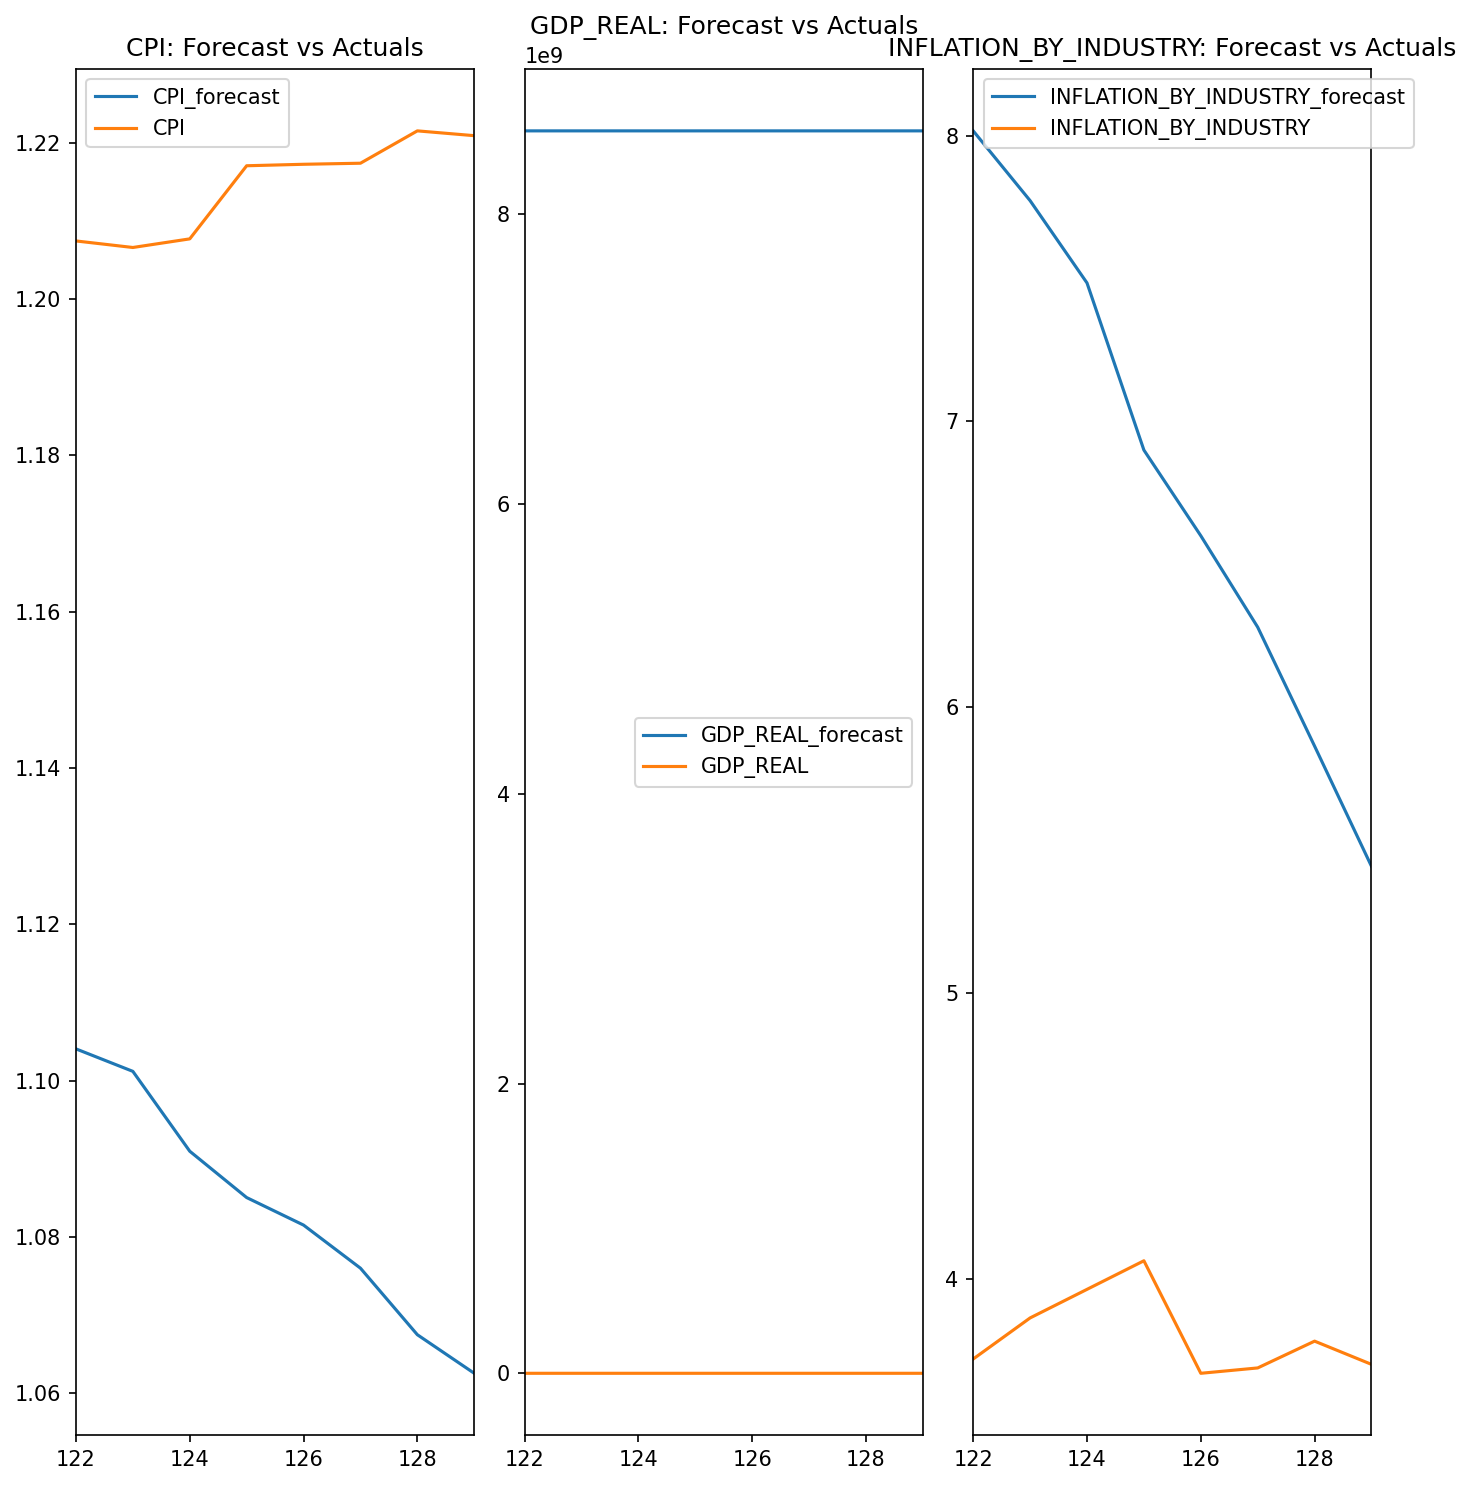

In [193]:
fig, axes = plt.subplots(nrows=int(len(macro_pd.columns)/2), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(macro_pd.columns, axes.flatten())):
    df_unscaled_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
plt.tight_layout()  

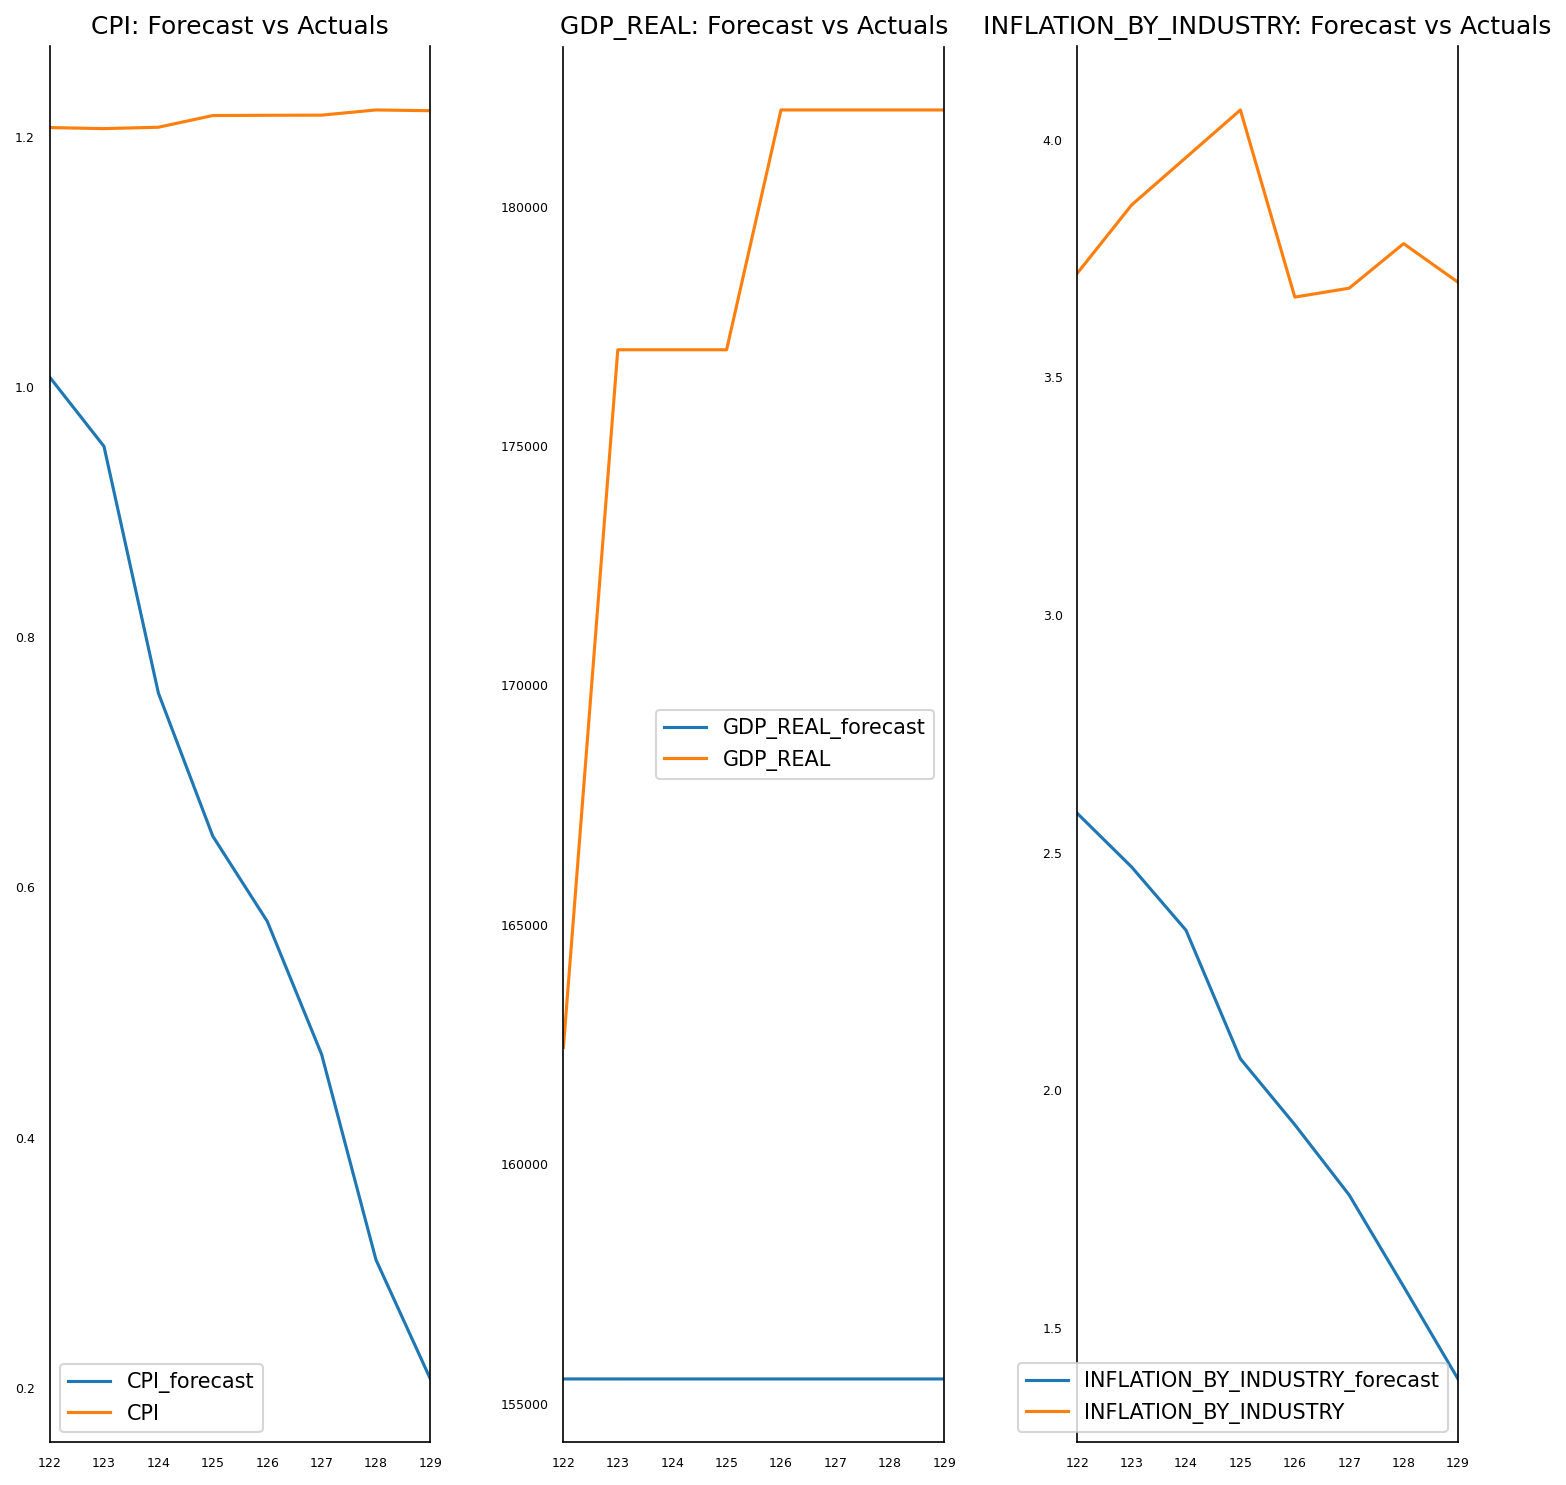

In [192]:
fig, axes = plt.subplots(nrows=int(len(macro_pd.columns)/2), ncols=3, dpi=150, figsize=(10,10))
for i, (col,ax) in enumerate(zip(macro_pd.columns, axes.flatten())):
    df_results[col+'_forecast'].plot(legend=True, ax=ax).autoscale(axis='x',tight=True)
    df_test[col][-nobs:].plot(legend=True, ax=ax);
    ax.set_title(col + ": Forecast vs Actuals")
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    ax.spines["top"].set_alpha(0)
    ax.tick_params(labelsize=6)

plt.tight_layout();